In [1]:
# ### mount on google drive
# from google.colab import drive
# drive.mount('/content/drive/')
# import os
# os.chdir("/content/drive/My Drive/WatNet/notebooks")
# # # !pip install rasterio

In [2]:
import os
os.chdir('..')
import glob
import time
import random
import numpy as np
import tensorflow as tf
from notebooks import config
import matplotlib.pyplot as plt
from dataloader.img_aug import img_aug
from utils.acc_eval import acc_patch
from utils.imgShow import imgShow, imsShow
from model.seg_model.watnet import watnet
from model.seg_model.deeplabv3_plus import deeplabv3_plus
from model.seg_model.deepwatermapv2 import deepwatermapv2
from dataloader.tfrecord_io import parse_image,parse_shape,toPatchPair



(4, 64, 64, 128) (4, 8, 8, 2048)


## Data loading
### _Load and parse the tfrecord data_

In [3]:
### data loading from .tfrecord file
path_tra_data = 'data/tfrecord-s2/tra_data.tfrecords'
path_val_data = 'data/tfrecord-s2/val_data.tfrecords'
## training data
tra_dset = tf.data.TFRecordDataset(path_tra_data)
tra_dset = tra_dset.map(parse_image).map(parse_shape)\
            .cache()\
            .map(toPatchPair)\
            .map(img_aug)
tra_dset = tra_dset.shuffle(config.buffer_size).batch(config.batch_size)

## validation data
val_dset = tf.data.TFRecordDataset(path_val_data)
val_dset = val_dset.map(parse_image).map(parse_shape)\
            .map(toPatchPair)
val_dset = val_dset.batch(4)


In [4]:
# # for i in range(5):
# start = time.time()
# i = 1
# for patch, truth in tra_dset:
#     i+=1
# imsShow(img_list=[patch[0], truth[0]], 
#     img_name_list=['patch', 'truth'],
#     clip_list=[2,0]
#     )
# plt.show()
# print('num:', i)
# print('time:', time.time()-start)


In [5]:
## model configuration
# model = watnet(input_shape=(config.patch_size, config.patch_size, config.num_bands), nclasses=2)
model = deeplabv3_plus(nclasses=2, input_shape=(512,512,6))
# model = deepwatermapv2(min_width=4)


In [6]:
'''------1. train step------'''
@tf.function
def train_step(model, loss_fun, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=True)
        loss = loss_fun(y, y_pre)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    config.tra_loss.update_state(loss)
    config.tra_oa.update_state(y, y_pre)
    config.tra_miou.update_state(y, y_pre)
    return config.tra_loss.result(), config.tra_oa.result(), config.tra_miou.result()

'''------2. test step------'''
@tf.function
def test_step(model, loss_fun, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=False)
        loss = loss_fun(y, y_pre)
    config.val_loss.update_state(loss) 
    config.val_oa.update_state(y, y_pre)
    config.val_miou.update_state(y, y_pre)
    return config.val_loss.result(), config.val_oa.result(), config.val_miou.result()

'''------3. train loops------'''
def train_loops(model, loss_fun, optimizer, tra_dset, val_dset, epochs):
    max_miou_pre = 0.8
    for epoch in range(epochs):
        start = time.time()
        ###--- train the model ---
        for x_batch, y_batch in tra_dset:
            tra_loss_epoch, tra_oa_epoch,tra_miou_epoch = train_step(model, loss_fun, optimizer, x_batch, y_batch)        
        ### --- test the model ---
        for x_batch, y_batch in val_dset:
            val_loss_epoch, val_oa_epoch, val_miou_epoch = test_step(model, loss_fun, x_batch, y_batch)
        ### --- update the metrics ---
        config.tra_loss.reset_states(), config.tra_oa.reset_states(), config.tra_miou.reset_states()
        config.val_loss.reset_states(), config.val_oa.reset_states(), config.val_miou.reset_states()
        format = 'Ep {}: traLoss:{:.3f},traOA:{:.3f},traMIoU:{:.3f},valLoss:{:.3f},valOA:{:.3f},valMIoU:{:.3f},time:{:.0f}s'
        print(format.format(epoch + 1, tra_loss_epoch, tra_oa_epoch, tra_miou_epoch, val_loss_epoch, val_oa_epoch, val_miou_epoch, time.time() - start))
        ## --- visualize the results ---
        if epoch%10 == 0:
            i = np.random.randint(config.batch_size)
            for val_patch, val_truth in val_dset.take(1):
                plt.figure(figsize=(10,4))
                pre = model(val_patch, training=False)
                imsShow(img_list=[val_patch.numpy()[i], val_truth.numpy()[i], pre.numpy()[i]], \
                        img_name_list=['val_patch', 'val_truth', 'prediction'], \
                        clip_list=[2,0,0],\
                        color_bands_list=None)
                plt.show()


Ep 1: traLoss:0.431,traOA:0.854,traMIoU:0.706,valLoss:0.931,valOA:0.190,valMIoU:0.100,time:20s


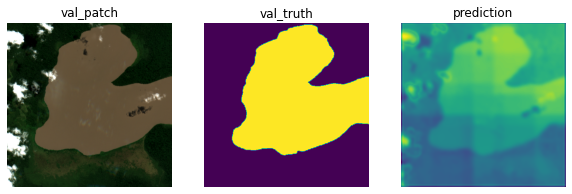

Ep 2: traLoss:0.294,traOA:0.922,traMIoU:0.806,valLoss:0.694,valOA:0.772,valMIoU:0.386,time:11s
Ep 3: traLoss:0.201,traOA:0.921,traMIoU:0.813,valLoss:0.750,valOA:0.772,valMIoU:0.386,time:11s
Ep 4: traLoss:0.172,traOA:0.929,traMIoU:0.822,valLoss:0.817,valOA:0.772,valMIoU:0.386,time:11s
Ep 5: traLoss:0.141,traOA:0.947,traMIoU:0.865,valLoss:0.892,valOA:0.772,valMIoU:0.386,time:11s
Ep 6: traLoss:0.183,traOA:0.932,traMIoU:0.823,valLoss:0.888,valOA:0.772,valMIoU:0.386,time:11s
Ep 7: traLoss:0.185,traOA:0.920,traMIoU:0.805,valLoss:0.964,valOA:0.772,valMIoU:0.386,time:11s
Ep 8: traLoss:0.200,traOA:0.931,traMIoU:0.834,valLoss:1.090,valOA:0.772,valMIoU:0.386,time:11s
Ep 9: traLoss:0.165,traOA:0.942,traMIoU:0.853,valLoss:1.051,valOA:0.772,valMIoU:0.386,time:11s
Ep 10: traLoss:0.176,traOA:0.929,traMIoU:0.831,valLoss:1.102,valOA:0.772,valMIoU:0.386,time:11s
Ep 11: traLoss:0.208,traOA:0.931,traMIoU:0.834,valLoss:0.866,valOA:0.772,valMIoU:0.386,time:11s


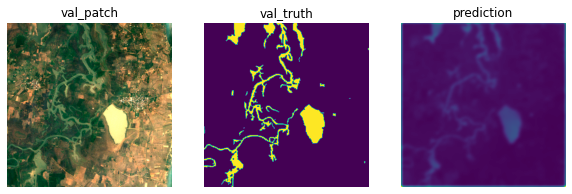

Ep 12: traLoss:0.135,traOA:0.954,traMIoU:0.879,valLoss:0.940,valOA:0.771,valMIoU:0.386,time:11s
Ep 13: traLoss:0.153,traOA:0.945,traMIoU:0.867,valLoss:0.794,valOA:0.772,valMIoU:0.387,time:11s
Ep 14: traLoss:0.189,traOA:0.928,traMIoU:0.818,valLoss:0.843,valOA:0.772,valMIoU:0.389,time:11s
Ep 15: traLoss:0.221,traOA:0.927,traMIoU:0.825,valLoss:0.507,valOA:0.777,valMIoU:0.400,time:11s
Ep 16: traLoss:0.142,traOA:0.945,traMIoU:0.870,valLoss:0.329,valOA:0.798,valMIoU:0.456,time:11s
Ep 17: traLoss:0.098,traOA:0.969,traMIoU:0.922,valLoss:0.226,valOA:0.891,valMIoU:0.700,time:11s
Ep 18: traLoss:0.158,traOA:0.941,traMIoU:0.853,valLoss:0.261,valOA:0.858,valMIoU:0.612,time:11s
Ep 19: traLoss:0.125,traOA:0.952,traMIoU:0.874,valLoss:0.320,valOA:0.851,valMIoU:0.603,time:11s
Ep 20: traLoss:0.112,traOA:0.962,traMIoU:0.893,valLoss:0.243,valOA:0.883,valMIoU:0.679,time:11s
Ep 21: traLoss:0.146,traOA:0.949,traMIoU:0.876,valLoss:0.318,valOA:0.828,valMIoU:0.533,time:11s


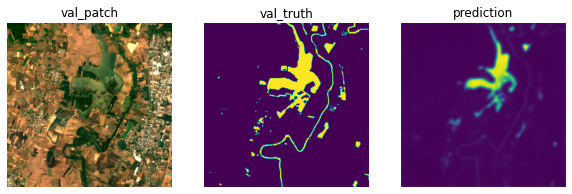

Ep 22: traLoss:0.120,traOA:0.955,traMIoU:0.893,valLoss:0.187,valOA:0.938,valMIoU:0.829,time:11s
Ep 23: traLoss:0.131,traOA:0.950,traMIoU:0.867,valLoss:0.131,valOA:0.963,valMIoU:0.896,time:11s
Ep 24: traLoss:0.152,traOA:0.946,traMIoU:0.874,valLoss:0.113,valOA:0.967,valMIoU:0.908,time:11s
Ep 25: traLoss:0.118,traOA:0.959,traMIoU:0.894,valLoss:0.138,valOA:0.954,valMIoU:0.878,time:11s
Ep 26: traLoss:0.122,traOA:0.955,traMIoU:0.885,valLoss:0.120,valOA:0.961,valMIoU:0.894,time:11s
Ep 27: traLoss:0.121,traOA:0.958,traMIoU:0.889,valLoss:0.111,valOA:0.965,valMIoU:0.902,time:11s
Ep 28: traLoss:0.125,traOA:0.956,traMIoU:0.889,valLoss:0.175,valOA:0.933,valMIoU:0.816,time:11s
Ep 29: traLoss:0.103,traOA:0.965,traMIoU:0.912,valLoss:0.104,valOA:0.971,valMIoU:0.918,time:11s
Ep 30: traLoss:0.090,traOA:0.967,traMIoU:0.912,valLoss:0.104,valOA:0.968,valMIoU:0.911,time:11s
Ep 31: traLoss:0.111,traOA:0.959,traMIoU:0.894,valLoss:0.170,valOA:0.945,valMIoU:0.847,time:11s


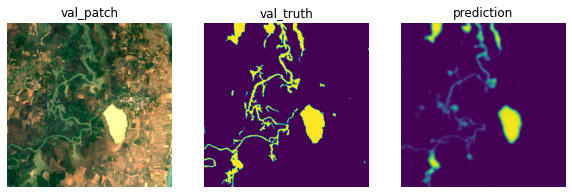

Ep 32: traLoss:0.115,traOA:0.956,traMIoU:0.894,valLoss:0.478,valOA:0.896,valMIoU:0.715,time:11s
Ep 33: traLoss:0.127,traOA:0.955,traMIoU:0.886,valLoss:0.729,valOA:0.901,valMIoU:0.735,time:11s
Ep 34: traLoss:0.088,traOA:0.968,traMIoU:0.920,valLoss:0.231,valOA:0.950,valMIoU:0.864,time:11s
Ep 35: traLoss:0.095,traOA:0.965,traMIoU:0.909,valLoss:0.160,valOA:0.963,valMIoU:0.897,time:11s
Ep 36: traLoss:0.240,traOA:0.919,traMIoU:0.801,valLoss:4.782,valOA:0.545,valMIoU:0.372,time:11s
Ep 37: traLoss:0.136,traOA:0.953,traMIoU:0.882,valLoss:0.320,valOA:0.945,valMIoU:0.852,time:11s
Ep 38: traLoss:0.151,traOA:0.948,traMIoU:0.873,valLoss:0.106,valOA:0.969,valMIoU:0.917,time:11s
Ep 39: traLoss:0.154,traOA:0.949,traMIoU:0.871,valLoss:0.105,valOA:0.970,valMIoU:0.918,time:11s
Ep 40: traLoss:0.100,traOA:0.962,traMIoU:0.901,valLoss:0.212,valOA:0.926,valMIoU:0.823,time:11s
Ep 41: traLoss:0.093,traOA:0.967,traMIoU:0.920,valLoss:0.169,valOA:0.944,valMIoU:0.861,time:11s


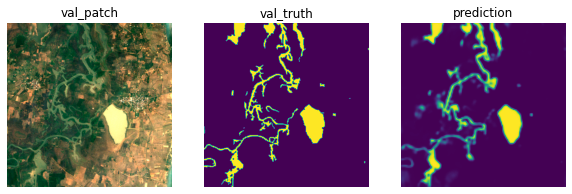

Ep 42: traLoss:0.099,traOA:0.966,traMIoU:0.910,valLoss:0.182,valOA:0.937,valMIoU:0.845,time:11s
Ep 43: traLoss:0.096,traOA:0.965,traMIoU:0.908,valLoss:0.132,valOA:0.949,valMIoU:0.874,time:11s
Ep 44: traLoss:0.110,traOA:0.962,traMIoU:0.905,valLoss:0.176,valOA:0.921,valMIoU:0.815,time:11s
Ep 45: traLoss:0.094,traOA:0.967,traMIoU:0.912,valLoss:0.132,valOA:0.945,valMIoU:0.864,time:11s
Ep 46: traLoss:0.105,traOA:0.963,traMIoU:0.910,valLoss:0.097,valOA:0.968,valMIoU:0.915,time:11s
Ep 47: traLoss:0.107,traOA:0.964,traMIoU:0.911,valLoss:0.061,valOA:0.977,valMIoU:0.937,time:11s
Ep 48: traLoss:0.090,traOA:0.970,traMIoU:0.921,valLoss:0.056,valOA:0.980,valMIoU:0.946,time:11s
Ep 49: traLoss:0.077,traOA:0.972,traMIoU:0.917,valLoss:0.055,valOA:0.982,valMIoU:0.951,time:11s
Ep 50: traLoss:0.088,traOA:0.967,traMIoU:0.907,valLoss:0.053,valOA:0.983,valMIoU:0.953,time:11s
Ep 51: traLoss:0.077,traOA:0.972,traMIoU:0.927,valLoss:0.051,valOA:0.981,valMIoU:0.947,time:11s


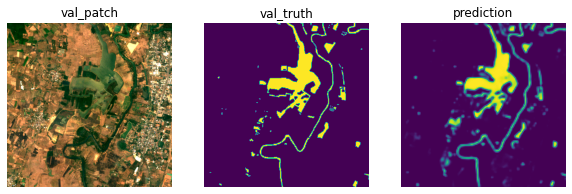

Ep 52: traLoss:0.077,traOA:0.973,traMIoU:0.934,valLoss:0.049,valOA:0.982,valMIoU:0.950,time:11s
Ep 53: traLoss:0.074,traOA:0.972,traMIoU:0.920,valLoss:0.049,valOA:0.982,valMIoU:0.950,time:11s
Ep 54: traLoss:0.085,traOA:0.969,traMIoU:0.920,valLoss:0.057,valOA:0.978,valMIoU:0.941,time:11s
Ep 55: traLoss:0.076,traOA:0.973,traMIoU:0.930,valLoss:0.053,valOA:0.981,valMIoU:0.947,time:11s
Ep 56: traLoss:0.072,traOA:0.974,traMIoU:0.931,valLoss:0.051,valOA:0.981,valMIoU:0.947,time:11s
Ep 57: traLoss:0.081,traOA:0.968,traMIoU:0.919,valLoss:0.059,valOA:0.977,valMIoU:0.938,time:11s
Ep 58: traLoss:0.100,traOA:0.965,traMIoU:0.912,valLoss:0.060,valOA:0.977,valMIoU:0.937,time:11s
Ep 59: traLoss:0.099,traOA:0.964,traMIoU:0.907,valLoss:0.067,valOA:0.976,valMIoU:0.935,time:11s
Ep 60: traLoss:0.090,traOA:0.966,traMIoU:0.913,valLoss:0.063,valOA:0.980,valMIoU:0.944,time:11s
Ep 61: traLoss:0.108,traOA:0.965,traMIoU:0.906,valLoss:0.068,valOA:0.980,valMIoU:0.944,time:11s


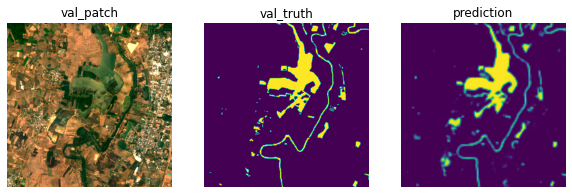

Ep 62: traLoss:0.110,traOA:0.954,traMIoU:0.883,valLoss:0.065,valOA:0.979,valMIoU:0.942,time:11s
Ep 63: traLoss:0.086,traOA:0.967,traMIoU:0.911,valLoss:0.058,valOA:0.981,valMIoU:0.947,time:11s
Ep 64: traLoss:0.096,traOA:0.968,traMIoU:0.918,valLoss:0.057,valOA:0.980,valMIoU:0.944,time:11s
Ep 65: traLoss:0.080,traOA:0.970,traMIoU:0.926,valLoss:0.058,valOA:0.979,valMIoU:0.944,time:11s
Ep 66: traLoss:0.081,traOA:0.972,traMIoU:0.925,valLoss:0.051,valOA:0.982,valMIoU:0.950,time:11s
Ep 67: traLoss:0.087,traOA:0.966,traMIoU:0.912,valLoss:0.055,valOA:0.981,valMIoU:0.947,time:11s
Ep 68: traLoss:0.087,traOA:0.966,traMIoU:0.909,valLoss:0.048,valOA:0.983,valMIoU:0.953,time:11s
Ep 69: traLoss:0.093,traOA:0.969,traMIoU:0.916,valLoss:0.056,valOA:0.981,valMIoU:0.948,time:11s
Ep 70: traLoss:0.080,traOA:0.969,traMIoU:0.923,valLoss:0.053,valOA:0.981,valMIoU:0.948,time:11s
Ep 71: traLoss:0.071,traOA:0.973,traMIoU:0.932,valLoss:0.053,valOA:0.981,valMIoU:0.947,time:11s


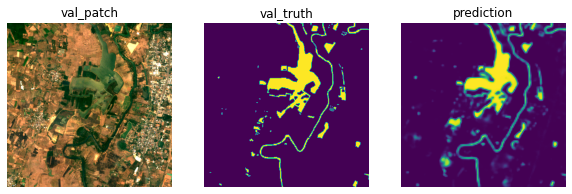

Ep 72: traLoss:0.070,traOA:0.976,traMIoU:0.935,valLoss:0.054,valOA:0.980,valMIoU:0.946,time:11s
Ep 73: traLoss:0.068,traOA:0.975,traMIoU:0.936,valLoss:0.052,valOA:0.981,valMIoU:0.948,time:11s
Ep 74: traLoss:0.087,traOA:0.969,traMIoU:0.922,valLoss:0.055,valOA:0.981,valMIoU:0.946,time:11s
Ep 75: traLoss:0.069,traOA:0.976,traMIoU:0.939,valLoss:0.055,valOA:0.979,valMIoU:0.943,time:11s
Ep 76: traLoss:0.079,traOA:0.972,traMIoU:0.930,valLoss:0.059,valOA:0.979,valMIoU:0.942,time:11s
Ep 77: traLoss:0.072,traOA:0.975,traMIoU:0.932,valLoss:0.052,valOA:0.981,valMIoU:0.949,time:11s
Ep 78: traLoss:0.075,traOA:0.972,traMIoU:0.929,valLoss:0.050,valOA:0.982,valMIoU:0.949,time:11s
Ep 79: traLoss:0.074,traOA:0.974,traMIoU:0.936,valLoss:0.049,valOA:0.982,valMIoU:0.950,time:11s
Ep 80: traLoss:0.071,traOA:0.974,traMIoU:0.930,valLoss:0.051,valOA:0.981,valMIoU:0.948,time:11s
Ep 81: traLoss:0.068,traOA:0.975,traMIoU:0.930,valLoss:0.050,valOA:0.982,valMIoU:0.949,time:11s


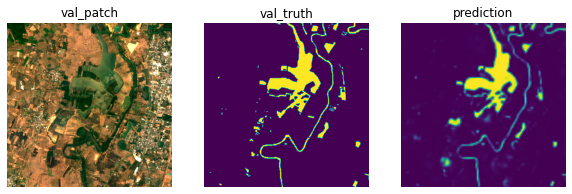

Ep 82: traLoss:0.069,traOA:0.975,traMIoU:0.933,valLoss:0.052,valOA:0.981,valMIoU:0.947,time:11s
Ep 83: traLoss:0.068,traOA:0.976,traMIoU:0.936,valLoss:0.049,valOA:0.982,valMIoU:0.950,time:11s
Ep 84: traLoss:0.063,traOA:0.977,traMIoU:0.940,valLoss:0.047,valOA:0.983,valMIoU:0.952,time:11s
Ep 85: traLoss:0.062,traOA:0.978,traMIoU:0.942,valLoss:0.046,valOA:0.983,valMIoU:0.953,time:11s
Ep 86: traLoss:0.080,traOA:0.971,traMIoU:0.925,valLoss:0.049,valOA:0.982,valMIoU:0.952,time:11s
Ep 87: traLoss:0.074,traOA:0.975,traMIoU:0.932,valLoss:0.047,valOA:0.983,valMIoU:0.952,time:11s
Ep 88: traLoss:0.064,traOA:0.978,traMIoU:0.945,valLoss:0.046,valOA:0.983,valMIoU:0.953,time:11s
Ep 89: traLoss:0.065,traOA:0.976,traMIoU:0.937,valLoss:0.045,valOA:0.983,valMIoU:0.954,time:11s
Ep 90: traLoss:0.069,traOA:0.975,traMIoU:0.934,valLoss:0.046,valOA:0.983,valMIoU:0.954,time:11s
Ep 91: traLoss:0.070,traOA:0.974,traMIoU:0.938,valLoss:0.047,valOA:0.983,valMIoU:0.954,time:11s


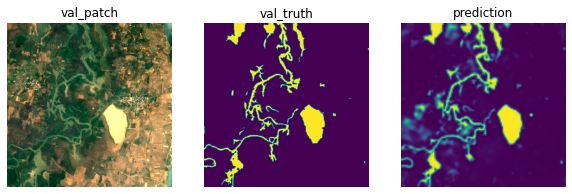

Ep 92: traLoss:0.060,traOA:0.980,traMIoU:0.945,valLoss:0.046,valOA:0.983,valMIoU:0.953,time:11s
Ep 93: traLoss:0.066,traOA:0.974,traMIoU:0.929,valLoss:0.045,valOA:0.983,valMIoU:0.952,time:11s
Ep 94: traLoss:0.061,traOA:0.977,traMIoU:0.941,valLoss:0.045,valOA:0.983,valMIoU:0.953,time:11s
Ep 95: traLoss:0.060,traOA:0.978,traMIoU:0.943,valLoss:0.046,valOA:0.983,valMIoU:0.953,time:11s
Ep 96: traLoss:0.069,traOA:0.974,traMIoU:0.932,valLoss:0.045,valOA:0.983,valMIoU:0.953,time:11s
Ep 97: traLoss:0.062,traOA:0.977,traMIoU:0.936,valLoss:0.045,valOA:0.983,valMIoU:0.953,time:11s
Ep 98: traLoss:0.058,traOA:0.978,traMIoU:0.944,valLoss:0.044,valOA:0.983,valMIoU:0.954,time:11s
Ep 99: traLoss:0.063,traOA:0.976,traMIoU:0.938,valLoss:0.043,valOA:0.984,valMIoU:0.955,time:11s
Ep 100: traLoss:0.065,traOA:0.976,traMIoU:0.939,valLoss:0.043,valOA:0.984,valMIoU:0.955,time:11s


In [7]:
## training
train_loops(model=model, \
            loss_fun=config.loss_bce, \
            optimizer=config.opt_adam, \
            tra_dset=tra_dset, \
            val_dset=val_dset, \
            epochs=config.epochs)


In [2]:
# ### model saving
# path_save = 'model/pretrained_model/deepwatermapv2.h5'
# model.save(path_save)

